In [163]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

## Algorithm

1. Initial clustering and merging:
    * identifies clusters based on spatio-temporal nearness
        * events must first be close in time $\to$ identifies many small clusters
        * adding a new event must be close to the statistical center of a cluster
    * adjacent clusters are merged when they not sufficiently separated 

2. Remaining clusters are 
```
clusters_1 = get_clusters_3(time_arr, noise_arr, dist_thresh, time_thresh)
clusters_2 = get_extended_clusters(time_arr, noise_arr, clusters_1, time_thresh)
clusters_3 = separate_embedded_clusters(clusters_2, True)
clusters_4 = merge_clusters_combo(time_arr, noise_arr, clusters_3, dist_thresh, time_thresh)
clusters_4 = sorted([sorted(c) for c in clusters_4])
clusters_5 = get_iqr_trimmed_clusters(noise_arr, clusters_4, 1.5);
```

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller
* check on the limits of time between adjacent clusters, esp. when they have the same mean and/or median
    * if at $x_a$ for $t_1$ then again at $x_a$ for $t_2$, duration between going from and back to $x_a$ should reflect some mimimal amount of time ($2\times$ travel and a stay), 
        * e.g. 
            * from $x_a$ to an unknown $x_b$ with a stay at $x_b$ of the miminum duration and then back to $x_a$ 
            * should satisfy some criterion or _there is no inbetween travel and $t_1$ and $t_2$ are part of the same cluster_
* check of the metrics for inter-subcluster gaps
    * these are also clusters but unlabeled after the first round of clustering

## Notes: 

* **Gaps** 
    * since there are subclusters for a given cluster which are separated by gaps, these gaps ...

### 1-stay
* gap-merging works well when good density; poorly when otherwise

## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.



In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Clustering

## Split the clusters which have a temporal gap

### IQR-plotting

For each sub-cluster, plot the quantile boxes with whistkers.

**Notes**
* the boxes usually capture the baseline of the underlying stay
* the forward and backward clusters
    * usually the same clusters in the stays with similar IQRs
    * usually different in the 

### From here

At this point, it seems that the basic clusters are formed. 

Next, use the IQRs of these clusters as the new bounds for extending the cluster: essentially using the extensible box method.

Note that the IQR can be larger than the allow distance threshold; the box would therefore need to be the smaller of the two but with the same mean and/or median

### Summary

1. `get_clusters_x` finds the clusters based on nearness of events in space and time
2. `merge_clusters` merges neraby clusters based on ...
3. `merge_clusters_2`  merges neraby clusters based on ...
4. `extend_clusters` extend the clusters
5. `separate_clusters` break the overlapping clusters and then re-merge
6. `merge_clusters_2` merge the separated clusters
7. `intersect` the forward and backward clusters

In [8]:
from helper__3stays_v3_scripts import switch_indices

In [165]:
from synthetic_data.plotting import plot_trajectory, add_plot_trajectory, add_plot_seg_boxes

In [169]:
from helper__3stays_v3_scripts__plotting import plot_cluster_boxplots, add_plot_cluster_boxplots

In [10]:
from helper__3stays_v3_scripts__eval import get_segments_scores

In [11]:
print_clusts = lambda cluster_list : [print(f"[{c[0]:4d},{c[-1]:4d}]") for c in cluster_list]
#print_ctimes = lambda cluster_list : [print(f"[{time_arr[c[0]]:6.3f},{time_arr[c[-1]]:6.3f}]") for c in cluster_list]
#print_ctdiff = lambda cluster_list : [print(f"{time_arr[c[-1]] - time_arr[c[0]]:6.3f}") for c in cluster_list]
#print_times = lambda l: list(map(lambda x: f"{x:6.3f}",l))

# Start here

In [12]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
#from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes

from synthetic_data.trajectory_class import get_trajectory
#from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [13]:
from synthetic_data.canonical_stays import get3e, get3

In [14]:
from helper__get_clusters import get_clusters_1, get_clusters_2, get_clusters_3, get_clusters_4

In [15]:
time_thresh = 1/6
dist_thresh=0.25

In [16]:
rand_range = lambda min_, max_, size: (max_-min_)*np.random.random_sample(size=size) + min_

In [17]:
event_frac = rand_range(0.01,0.001, 1)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

print(f"Event frac. = {event_frac:6.3f}\nDupli. frac. = {duplicate_frac:6.3f}")

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

Event frac. =  0.009
Dupli. frac. =  0.000


1.6944285894324094 4.8083214112224715 0.9751712137183253
[0] False


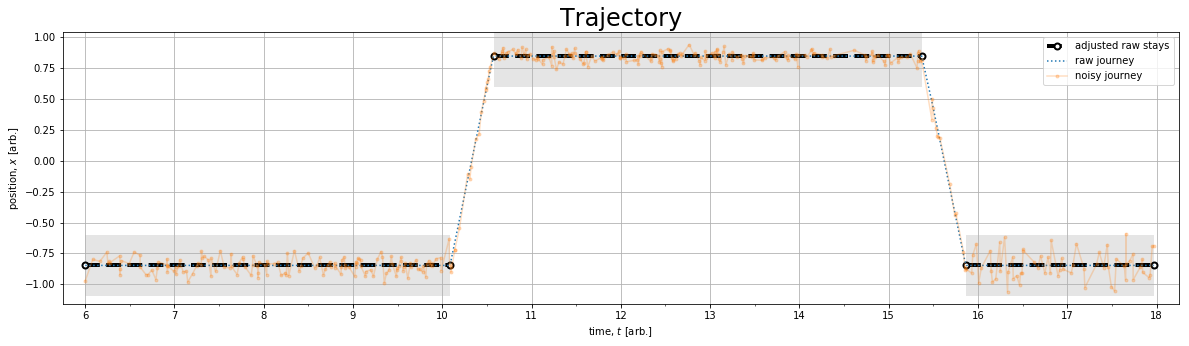

In [72]:
x_dist = rand_range(0.52,5.0, 10)[0]
mid_len = rand_range(0.2, 8, 10)[0]
shift = rand_range(-5, 5, 21)[0]

print(x_dist, mid_len, shift)
val = np.random.randint(0,2,1)
print(val, bool(val))
if val:
    stays = get3(x_dist, mid_len, shift)
else:
    stays = get3e(x_dist, mid_len, shift)    

continuation = True
n = 0
while continuation:
    try:
        time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
        continuation = False
    except:
        print("Failed")
        if n > 10: 
            continuation = False
        else:
            n+=1
        pass
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, dist_thresh);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.set_xlim([5.75,18.25]);

In [78]:
from helper__3stays_v3_scripts import get_extended_clusters, separate_clusters
from helper__gaps import merge_clusters_combo
from helper__metric_box__explore import eval_synth_data

In [20]:
def split_list( l1, l2): 
    
    """
    Usage:
    split_list(range(10), list(range(4,7)))
    ([0, 1, 2, 3], [4, 5, 6], [7, 8, 9])
    """
    
    if len(l1) < len(l2):
        return ([e for e in l2 if e < min(l1)], l1, [e for e in l2 if e > max(l1)])
    else:
        return ([e for e in l1 if e < min(l2)], l2, [e for e in l1 if e > max(l2)])        

def list_intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 


def contains(a1,a2,b1,b2):
    """
    Check whether one range contains another
    """    
    return ((a1 >= b1) & (a2 <= b2))

inter_bounds = lambda p1, p2: intersecting_bounds(p1[0],p1[-1],p2[0],p2[-1])
conta_bounds = lambda p1, p2: contains(p1[0],p1[-1],p2[0],p2[-1])

def intersecting_bounds(a1,a2,b1,b2):
    """
    Check whether two ranges intersect
    
    Specifically: b1 < a1 < b2 and a2 > b2
    """

    cond1 = ((a1 >= b1) & (a1 <= b2)) | \
            ((b1 >= a1) & (b1 <= a2))    
    
    return cond1

'''
def intersecting_bounds(a1,a2,b1,b2):
    """
    Check whether two ranges intersect
    
    Specifically: b1 < a1 < b2 and a2 > b2
    """
    print(a1,a2,b1,b2)
    
    print((a1 >  b1), (a1 <= b2), (a2 >= b2))
    print((a1 >= b1), (a1 <  b2), (a2 >  b2))
    
    cond1 = (((a1 >  b1) & (a1 < b2)) & (a2 > b2)) | \
             (((a1 > b1) & (a1 < b2)) & (a2 > b2))
    return cond1
'''

def get_sorted_keys(clusts):
    d = {}
    for n, c in enumerate(clusts):
        d[n] = len(c)

    return [k for k, v in sorted(d.items(), key=lambda item: item[1])]

def check_intersecting_clusters_inds(clusters):
    m = 0
    while (m < len(clusters)):
        # Biggest cluster
        c1 = clusters[m]
        n = m+1
        while (n < len(clusters)):

            if n == m:
                n+=1
                continue

            c2 = clusters[n]
            if inter_bounds(c1,c2):
                return True, m,n
            else:
                n+=1
        m+=1
    return False, 999, 999

def check_intersecting_clusters(clusters):
    
    result, _ , _ = check_intersecting_clusters_inds(clusters)
 
    return result

def separate_clusters_hier(clusters, verbose=False):
    """
    
    Test:
    clusts = [list(range(2,4)), list(range(8)), list(range(4,8)), list(range(6,10))]
    separate_clusters_hier(clusts)
    [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
    """    
    # Check if any clusters intersect
    new_clusts = clusters.copy()
    
    result, m, n = check_intersecting_clusters_inds(new_clusts)
    
    if verbose: print(result)    
    
    if result:
        if verbose: print(m, n)
    else:
        return clusters

    while result:
        
        if verbose: print_clusts(new_clusts)
        if verbose: print(len(new_clusts))
        c1 = new_clusts.pop(m)
        if m < n: 
            n-=1
        c2 = new_clusts.pop(n)

        if verbose: print(len(new_clusts))
        if verbose: print(f"{m:4d}: [{c1[0]:4d},{c1[-1]:4d}] and [{c2[0]:4d},{c2[-1]:4d}]")

        '''sc1 = set(c1)
        sc2 = set(c2)

        intersexion = sc1.intersection(sc2)

        sc1_diff = sc1.difference(intersexion)
        sc2_diff = sc2.difference(intersexion)                
        '''
        
        sc1_diff, intersec, sc2_diff = split_list(c1,c2)        
        
        #sc1_diff = list(sc1_diff)
        if len(sc1_diff) > 0:
            new_clusts.append(sc1_diff)
        if verbose: print("len(sc1_diff)",len(sc1_diff))
        
        #intersexion = list(intersexion)
        if len(intersec) > 0:
            new_clusts.append(intersec)
        if verbose: print("len(intersexion)",len(intersec))
        
        #sc2_diff = list(sc2_diff)
        if len(sc2_diff) > 0:
            new_clusts.append(sc2_diff)
        if verbose: print("len(sc2_diff)",len(sc2_diff))
        
        if verbose: print(len(new_clusts))
        if verbose: print_clusts(new_clusts) 
        
        result, m, n = check_intersecting_clusters_inds(new_clusts)
        if verbose: print(result,m,n)
        if verbose: print()
        
    return new_clusts

In [21]:
from helper__metric_box__explore import get_iqr_mask

In [24]:
def contiguous_sublists(lst1, lst2): 
    """
    Split intersecting and interleaved lists 
    into maximal contiguous sublists
    """
    #print(lst1, lst2)
    # Gather all unique elements together and order
    lst3 = sorted(list(set(lst1+lst2)))

    # Classifying function according to origin and intersections
    def get_flag(e):
        if (e in lst1) & (e in lst2):
            return 0
        elif (e in lst1):
            return 1
        else:
            return 2
    
    # output list
    all_lists = []
    
    # Initializations
    e = lst3[0]    
    flag = get_flag(e)
    lst = [e]
    
    # Walk through all elements
    for e in lst3[1:]:
        flag_ = get_flag(e)
        
        if flag == flag_:
            lst.append(e)
        else:
            all_lists.append(lst)
            lst = [e]
            flag = flag_
    
    # close the last list
    all_lists.append(lst)        
    
    # Sort the lists (maybe unnecessary)
    #all_lists = sorted([l for l in all_lists if l != []])
    
    return all_lists    

In [25]:
def separate_embedded_clusters(clusters, verbose=False):
    """
    
    Test:
    clusts = [list(range(5)), list(range(2,4)), list(range(8)), list(range(4,8)), list(range(6,10))]
    separate_embedded_clusters(clusts)
    [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
    """    
    # Check if any clusters intersect
    new_clusts = clusters.copy()
    
    result, m, n = check_intersecting_clusters_inds(new_clusts)
    
    if verbose: print(result)    
    
    if result:
        if verbose: print(m, n)
    else:
        return clusters

    while result:
        
        #if verbose: print_clusts(new_clusts)
        if verbose: print(len(new_clusts))
        c1 = new_clusts.pop(m)
        if m < n: 
            n-=1
        c2 = new_clusts.pop(n)

        if verbose: print(len(new_clusts))
        if verbose: print(f"{m:4d}: [{c1[0]:4d},{c1[-1]:4d}] and [{c2[0]:4d},{c2[-1]:4d}]")

        '''sc1 = set(c1)
        sc2 = set(c2)

        intersexion = sc1.intersection(sc2)

        sc1_diff = sc1.difference(intersexion)
        sc2_diff = sc2.difference(intersexion)                
        '''
        
        new_clusts.extend(contiguous_sublists(c1, c2))
        '''        
        sc1_diff, intersec, sc2_diff = split_list(c1,c2)        
        
        #sc1_diff = list(sc1_diff)
        if len(sc1_diff) > 0:
            new_clusts.append(sc1_diff)
        if verbose: print("len(sc1_diff)",len(sc1_diff))
        
        #intersexion = list(intersexion)
        if len(intersec) > 0:
            new_clusts.append(intersec)
        if verbose: print("len(intersexion)",len(intersec))
        
        #sc2_diff = list(sc2_diff)
        if len(sc2_diff) > 0:
            new_clusts.append(sc2_diff)
        if verbose: print("len(sc2_diff)",len(sc2_diff))
        '''
        if verbose: print(len(new_clusts))
        #if verbose: print_clusts(new_clusts) 
        
        result, m, n = check_intersecting_clusters_inds(new_clusts)
        if verbose: print(result,m,n)
        if verbose: print()

    return sorted(new_clusts)            

In [26]:
def get_iqr_trimmed_clusters(x_arr, clusters, iqr_factor=1.5, within=True, verbose=False):
    new_clusters = []
    for c in clusters:
        cc = get_iqr_mask(x_arr[c], c, iqr_factor, within)[0]
        
        ccc = list(range(cc[0], cc[-1]+1))
        
        if verbose: print(f"[{c[0]:4d},{c[-1]:4d}] vs. [{cc[0]:4d},{cc[-1]:4d}]")
        #f" vs. [{ccc[0]:4d},{ccc[-1]:4d}]" )

        new_clusters.append(ccc)
        
    return new_clusters

Event frac. =  0.005
Dupli. frac. =  0.000
 2.416,  1.499,  1.266
[1] True
Stage 1
5 Clusters:
[   0, 118]
[ 120, 125]
[ 126, 146]
[ 148, 152]
[ 153, 225]

Stage 2
3 Clusters:
[   0, 118]
[ 127, 147]
[ 153, 225]

Stage 3
False
3 Clusters:
[   0, 118]
[ 127, 147]
[ 153, 225]

Stage 4
No update

Stage 5
3 Clusters:
[   0, 116]
[ 127, 145]
[ 153, 223]

Predicted 3 of 3 true clusters 
	Cluster   0, [   0, 118]
		overlaps with 1 pred_cluster(s):
			[   0, 116]
			precision:  1.000;
			recall:  0.983

	Cluster   1, [ 127, 147]
		overlaps with 1 pred_cluster(s):
			[ 127, 145]
			precision:  1.000;
			recall:  0.905

	Cluster   2, [ 154, 225]
		overlaps with 1 pred_cluster(s):
			[ 153, 223]
			precision:  0.986;
			recall:  0.972

Stats: 
	min. precision:  0.986; min. recall:  0.905
	avg. precision:  0.995; avg. recall:  0.953
	tot. precision:  0.995; tot. recall:  0.972

Durations: 
tot. trajectory duration: 11.942 
tot. true stays duration: 11.129 (0.932%) 
tot. pred stays duration: 10.654

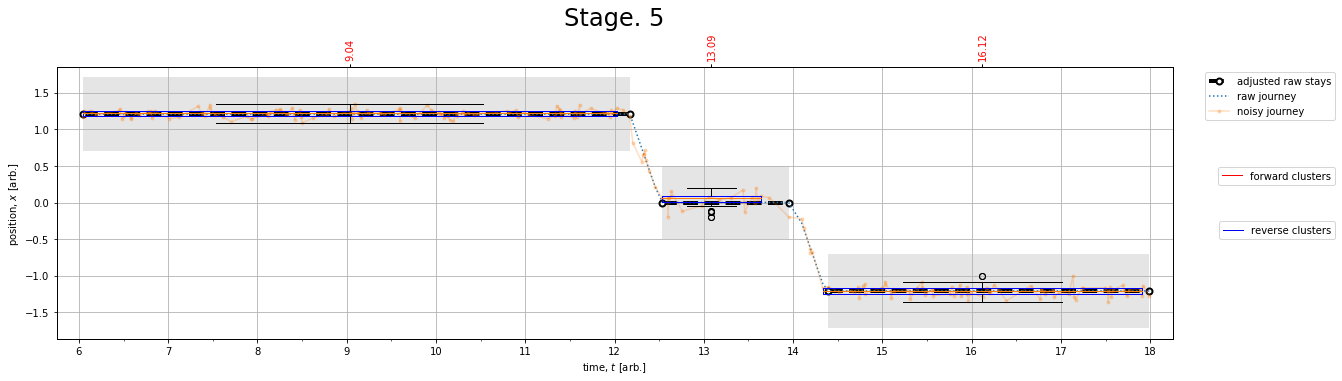

In [83]:
event_frac = rand_range(0.01,0.001, 1)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

print(f"Event frac. = {event_frac:6.3f}\nDupli. frac. = {duplicate_frac:6.3f}")

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}
x_dist = rand_range(0.52,5.0, 10)[0]
mid_len = rand_range(0.2, 8, 10)[0]
shift = rand_range(-5, 5, 21)[0]

print(f"{x_dist:6.3f}, {mid_len:6.3f}, {shift:6.3f}")
val = np.random.randint(0,2,1)
print(val, bool(val))
if val:
    stays = get3(x_dist, mid_len, shift)
else:
    stays = get3e(x_dist, mid_len, shift)    

continuation = True
n = 0
while continuation:
    try:
        time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
        continuation = False
    except:
        print("Failed")
        if n > 10: 
            continuation = False
        else:
            n+=1
        pass

t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

verbose = True

if verbose: print("Stage 1")
clusters_1 = get_clusters_3(time_arr, noise_arr, dist_thresh, time_thresh)
print(len(clusters_1), "Clusters:")
print_clusts(clusters_1);
print()

if verbose: print("Stage 2")
clusters_2 = get_extended_clusters(time_arr, noise_arr, clusters_1, time_thresh)
print(len(clusters_2), "Clusters:")
print_clusts(clusters_2);
print()

if verbose: print("Stage 3")
#clusters_3 = separate_clusters_hier(clusters_2, True)
if clusters_2 != clusters_1:
    clusters_3 = separate_embedded_clusters(clusters_2, True)
    print(len(clusters_3), "Clusters:")
    print_clusts(clusters_3);
else: 
    print("No update")    
    clusters_3 = clusters_2.copy()
print()    
    
if verbose: print("Stage 4")
if clusters_3 != clusters_2:    
    clusters_4 = merge_clusters_combo(time_arr, noise_arr, clusters_3, dist_thresh, time_thresh)
    print(len(clusters_4), "Clusters:")
    print_clusts(clusters_4);    
else: 
    print("No update")
    clusters_4 = clusters_3.copy()
print()

if verbose: print("Stage 5")
clusters_4 = sorted([sorted(c) for c in clusters_4])
iqr_trim = True
if iqr_trim:        
    clusters_5 = get_iqr_trimmed_clusters(noise_arr, clusters_4, 1.5);
    print(len(clusters_5), "Clusters:")
    print_clusts(clusters_5);
else: 
    print("No IQR-trim")
    clusters_5 = clusters_4.copy()
print()

get_segments_scores(time_arr, segments, clusters_5, True)

ylim = [noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh]
ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_5, switch_indices(clusters_5, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage. 5", fontsize=24);

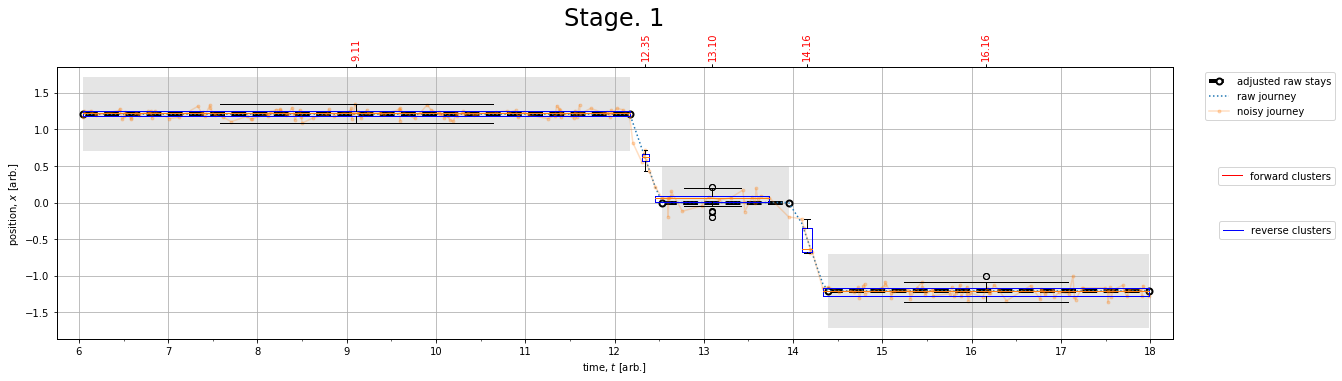

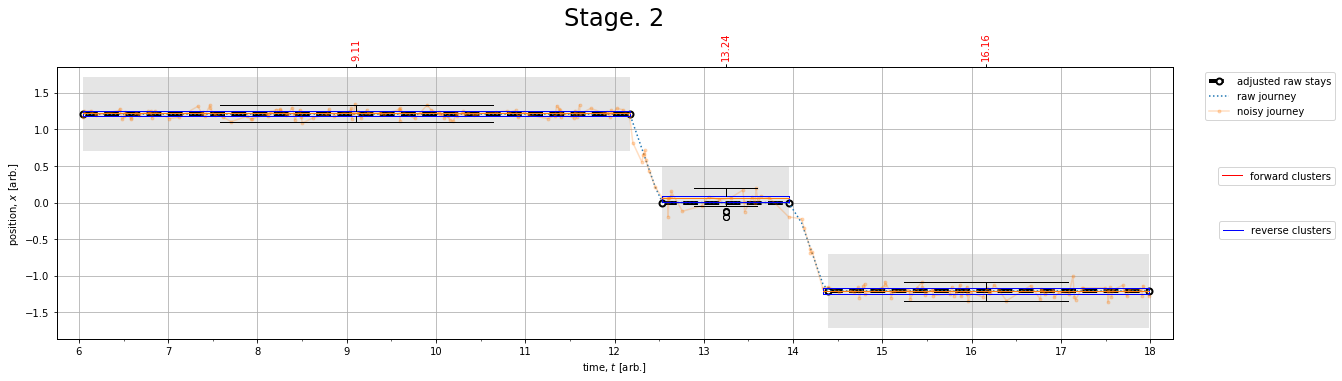

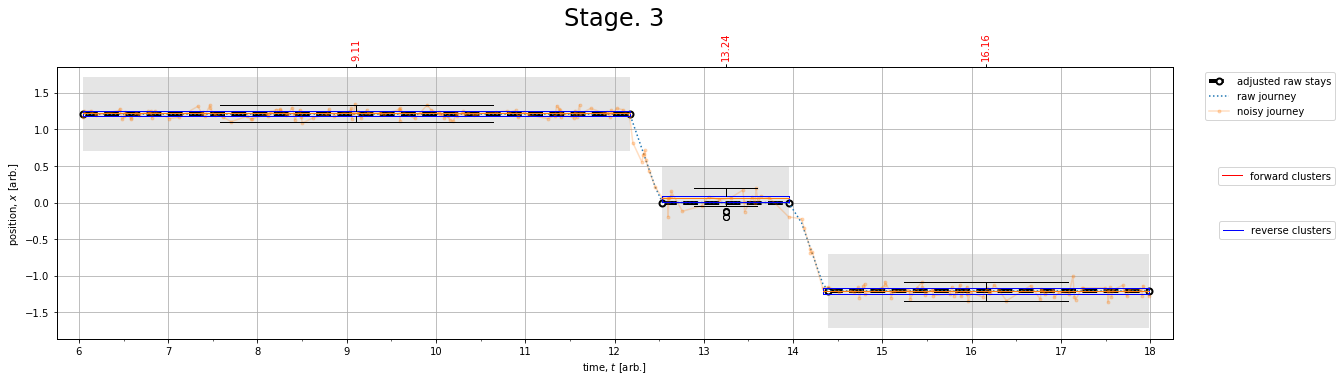

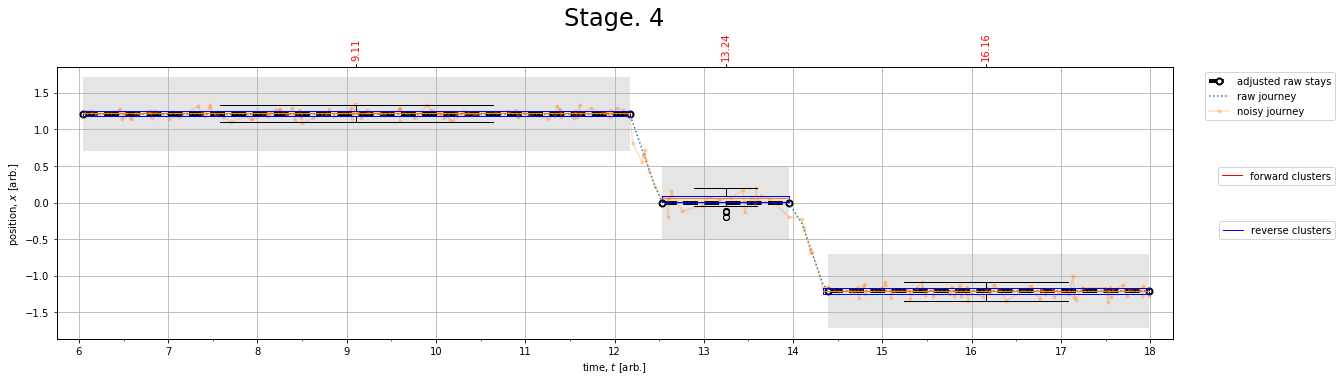

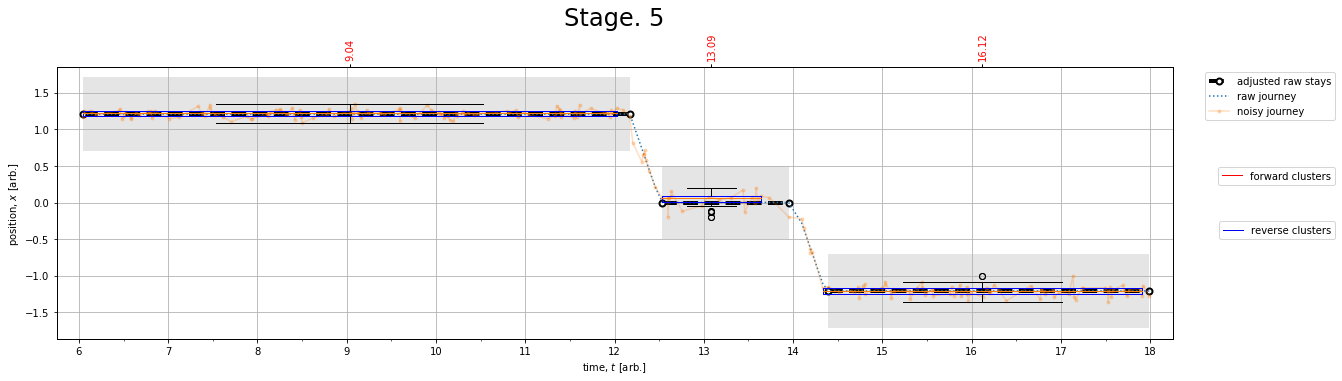

In [84]:
ylim = [noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh]


ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_1, switch_indices(clusters_1, time_arr.shape[0]), configs)
ax.set_ylim(ylim);
ax.set_title("Stage. 1", fontsize=24)

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_2, switch_indices(clusters_2, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage. 2", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_3, switch_indices(clusters_3, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage. 3", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_4, switch_indices(clusters_4, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage. 4", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_5, switch_indices(clusters_5, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage. 5", fontsize=24);


### Notes
#### 3 clusters
* overlapping clusters
    * embedded and also identitcal clusters
    * **Notes**
        * usually have the same median and mean ("M&M"), but not always
    * overlap on edge between two spatially close clusters
        * maybe not sharing M&M,
    * megacluster when two clusters share an $x$ (rare)
        * should be avoidable with gap durations
* missing short clusters
    * these usually occur on the edges
    * if using a IQR-postfilter, many of these will get dropped
    
#### 4 clusters
* mis-identified cluster, aka "floater"
    * part of a travel
        * in the canonical 3-stays, these are always between larger stays
        * **Todo** 
            * _check if these have insufficient events with the IQR-mask_
            * _check if these have insufficient duration with the IQR-mask_            
    * seems to be short in duration
* overlapping clusters
    * embedded and also identitcal clusters
    * **Notes**
        * usually have the same median and mean ("M&M"), but not always
    * overlap on edge between two spatially close clusters
        * maybe not sharing M&M,
    * megacluster when two clusters share an $x$ (rare)
        * should be avoidable with gap durations
    * missing short clusters and overlaps/duplicates

In [349]:
from synthetic_data.trajectory_class import pickle_trajectory
from datetime import datetime

import os

date_tag = datetime.today().strftime('%Y%m%d')
data_dir = f"./testdata_{date_tag}_4/"

try:
    os.makedirs(data_dir)
except OSError as e:
    print(e)

In [350]:
lens = []
precs = []
recs = []

width=5

total = width*width*(2*width+1)
print(total)

i = 0

length_criterion_break = False

verbose = False

index = 0
for x_dist in rand_range(2.05*dist_thresh,11.0, width):
    for mid_len in rand_range(0.2, 10, width):
        for shift in rand_range(-5, 5, 2*width+1):
            
            event_frac = rand_range(0.01,0.001, 1)[0]
            duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

            if verbose: print(f"Event frac. = {event_frac:6.3f}\nDupli. frac. = {duplicate_frac:6.3f}")

            configs = {
                'time_thresh':1/6,
                'dist_thresh':0.5,
                'event_frac':event_frac,
                'duplicate_frac':duplicate_frac,    
                'noise_min':0.02,
                'noise_max':0.15
            }            
            
            if verbose: print(f"{x_dist:6.3f}, {mid_len:6.3f}, {shift:6.3f}")
            
            val = np.random.randint(0,2,1)
            if val:
                stays = get3(x_dist, mid_len, shift)
            else:
                stays = get3e(x_dist, mid_len, shift)            
            
            continuation = True
            m = 0
            while continuation:
                n = 0
                try:
                    time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
                    t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))
                    continuation = False
                except:
                    print("Failed at",m,n)
                    if n > 10: 
                        continuation = False
                    else:
                        n+=1
                    pass

                try:

                    if verbose: print("Stage 1")
                    clusters_1 = get_clusters_3(time_arr, noise_arr, dist_thresh, time_thresh)
                    if verbose: print(len(clusters_1), "Clusters:")
                    if verbose: print_clusts(clusters_1);
                    if verbose: print()

                    if verbose: print("Stage 2")
                    clusters_2 = get_extended_clusters(time_arr, noise_arr, clusters_1, time_thresh)
                    if verbose: print(len(clusters_2), "Clusters:")
                    if verbose: print_clusts(clusters_2);
                    if verbose: print()

                    if verbose: print("Stage 3")
                    #clusters_3 = separate_clusters_hier(clusters_2, True)
                    if clusters_2 != clusters_1:
                        clusters_3 = separate_embedded_clusters(clusters_2)
                        if verbose: print(len(clusters_3), "Clusters:")
                        if verbose: print_clusts(clusters_3);
                    else: 
                        if verbose: print("No update")    
                        if verbose: clusters_3 = clusters_2.copy()
                    if verbose: print()    

                    if verbose: print("Stage 4")
                    if clusters_3 != clusters_2:    
                        clusters_4 = merge_clusters_combo(time_arr, noise_arr, clusters_3, dist_thresh, time_thresh)
                        if verbose: print(len(clusters_4), "Clusters:")
                        if verbose: print_clusts(clusters_4);    
                    else: 
                        if verbose: print("No update")
                        clusters_4 = clusters_3.copy()
                    if verbose: print()

                    if verbose: print("Stage 5")
                    clusters_4 = sorted([sorted(c) for c in clusters_4])
                    iqr_trim = True
                    if iqr_trim:        
                        clusters_5 = get_iqr_trimmed_clusters(noise_arr, clusters_4, 1.5);
                        if verbose: print(len(clusters_5), "Clusters:")
                        if verbose: print_clusts(clusters_5);
                    else: 
                        if verbose: print("No IQR-trim")
                        clusters_5 = clusters_4.copy()
                    if verbose: print()

                    continuation = False
                except:                    
                    print("Failed at",m)
                    print(stays)                    
                    if m > 10: 
                        break
                    else:
                        m+=1
                    pass
                
                prec, rec, conmat = eval_synth_data(segments, time_arr, clusters_5)
                
                if (prec < 0.75) | (rec < 0.75):
                    if (prec < 0.75) & (rec < 0.75):
                        print("p&r low")
                    elif (prec < 0.75):
                        print("p low")
                    else:
                        print("r low")
                    
                    all_clusters = [
                        clusters_1,
                        clusters_2,
                        clusters_3,
                        clusters_4,
                        clusters_5    
                    ]

                    fig, axs = plt.subplots(5,1,figsize=[20,30])

                    ylim = [noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh]

                    axs =axs.flatten()

                    for i in range(5):
                        try:
                            ax = axs[i]
                            add_plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, all_clusters[i], switch_indices(all_clusters[i], time_arr.shape[0]), configs, ax)
                            ax.set_ylim(ylim);
                            ax.set_title(f"Stage. {i}", fontsize=24)
                        except:
                            pass

                    fig.suptitle(f"prec. {prec:6.3f}, {rec:6.3f}", fontsize=16)

                    precstr = f"{prec:6.3f}".strip().replace(".","o")
                    recstr = f"{rec:6.3f}".strip().replace(".","o")

                    stays_tag = int((x_segs.size)/3)
                    notes = f"prec{precstr}_rec{recstr}"

                    trajectory_tag = f"trajectory_{stays_tag}stays__{notes}"
                    path_to_file =  data_dir + trajectory_tag
                    pickle_trajectory(time_arr, raw_arr, noise_arr, segments, path_to_file + ".pkl")
                    
                    plt.savefig(path_to_file + ".png")
                    plt.close()
                    
                    break
                    
                lens.append(len(clusters_5))
                precs.append(prec)
                recs.append(rec)
                
            if i % (width*width) == 0:
                print(f"{i:4d} of {total:5d}")
            i+=1

            if length_criterion_break: break
        if length_criterion_break: break
    if length_criterion_break: break
    
    index += 1
    
#print_clusts(clusters_5);

275










   0 of   275















































































































































Failed at 0 0













































































Failed at 0 0













































































  25 of   275













































































































































































































Failed at 0 0








Failed at 0 0








Failed at 0 0












Failed at 0 0
























Failed at 0
[{'type': 'stay', 'loc': 3.1819073769904755, 'start': 6.0, 'end': 6.266666666666667, 'slope': 0, 'noise': 0.054257560662492516}, {'type': 'stay', 'loc': 0, 'start': 7.175783060092517, 'end': 16.02331914038757, 'slope': 0, 'noise': 0.132779503810202}, {'type': 'stay', 'loc': -3.1819073769904755, 'start': 16.

In [351]:
print(len(precs),len(recs))

270 270


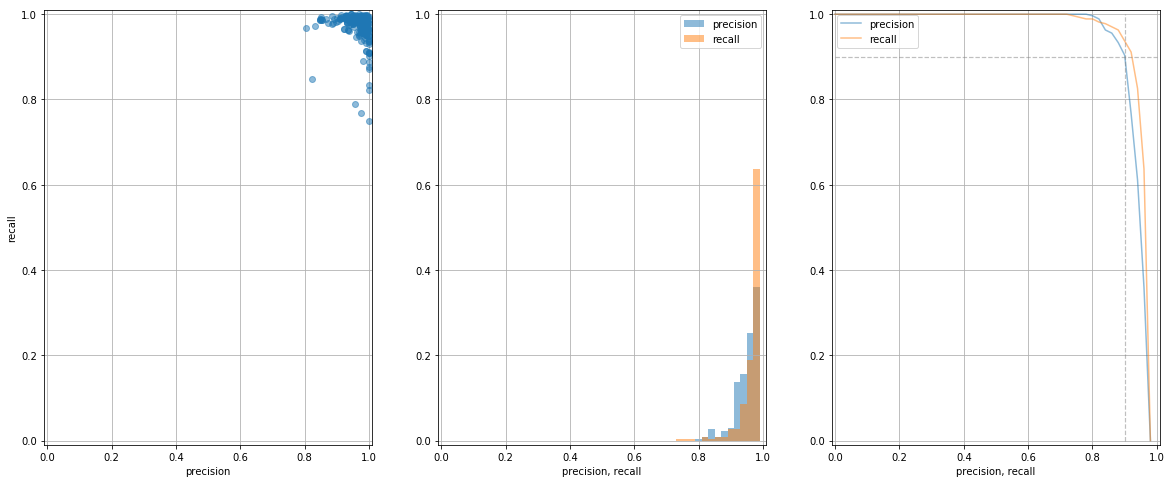

In [352]:
fig, axs = plt.subplots(1,3, figsize=[20,8])
axs = axs.flatten()
ax =axs[0]
ax.plot(precs, recs, 'o', alpha=0.5)
lims=[-.01,1.01]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("precision")
ax.set_ylabel("recall")
ax.grid()

binw=0.02
bins=np.arange(0.0,1.0+binw,binw)
hp, _ = np.histogram(np.array(precs), bins=bins, density=True)
hr, _ = np.histogram(np.array( recs), bins=bins, density=True)

ax = axs[1]
_ = ax.bar(bins[:-1], hp*binw, alpha=0.5, width=binw, align='center', label="precision")
_ = ax.bar(bins[:-1], hr*binw, alpha=0.5, width=binw, align='center', label="recall")
ax.set_xlabel("precision, recall")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.grid()
ax.legend();

ax = axs[2]
_ = ax.plot(bins[:-1], 1-np.cumsum(hp*binw), alpha=0.5,label="precision")
_ = ax.plot(bins[:-1], 1-np.cumsum(hr*binw), alpha=0.5,label="recall")
ax.plot([0.9,0.9],[0,1], '--', color='gray', lw=1.2, alpha=0.5)
ax.plot([0,1],[0.9,0.9], '--', color='gray', lw=1.2, alpha=0.5)
ax.set_xlabel("precision, recall")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.grid()
ax.legend()
fig.savefig(data_dir + "metrics.png")

## Revisit some bad files

In [212]:
!ls testdata_20200814/*.pkl

testdata_20200814/trajectory_3stays__prec0o949_rec0o597.pkl
testdata_20200814/trajectory_3stays__prec0o983_rec0o586.pkl
testdata_20200814/trajectory_3stays__prec0o987_rec0o510.pkl
testdata_20200814/trajectory_3stays__prec1o000_rec0o480.pkl
testdata_20200814/trajectory_3stays__prec1o000_rec0o511.pkl
testdata_20200814/trajectory_3stays__prec1o000_rec0o700.pkl


In [214]:
import pickle

In [274]:
trajectory = pickle.load( open("./testdata_20200814/trajectory_3stays__prec1o000_rec0o700.pkl", "rb") )

In [275]:
segments = trajectory['segments']
t_arr = trajectory['time_arr']
r_arr = trajectory['raw_locs_arr']
x_arr = trajectory['nse_locs_arr']

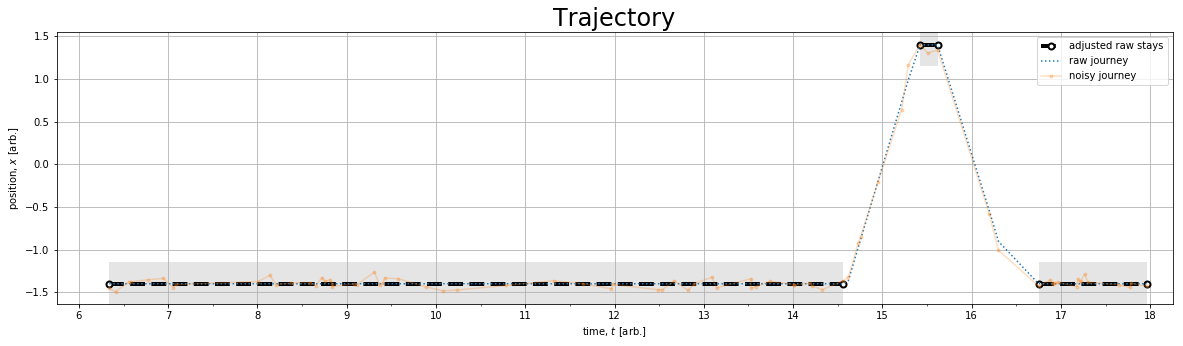

In [276]:
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, t_arr))

ax = plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.set_xlim([5.75,18.25]);

In [347]:
verbose = True
if verbose: print("Stage 1")
clusters_1 = get_clusters_3(t_arr, x_arr, dist_thresh, time_thresh)
if verbose: print(len(clusters_1), "Clusters:")
if verbose: print_clusts(clusters_1);
if verbose: print()

if verbose: print("Stage 2")
clusters_2 = get_extended_clusters(t_arr, x_arr, clusters_1, time_thresh)
if verbose: print(len(clusters_2), "Clusters:")
if verbose: print_clusts(clusters_2);
if verbose: print()

if verbose: print("Stage 3")
#clusters_3 = separate_clusters_hier(clusters_2, True)
if clusters_2 != clusters_1:
    #clusters_3 = separate_embedded_clusters(clusters_2)
    clusters_3 = separate_clusters_hier(clusters_2)
    if verbose: print(len(clusters_3), "Clusters:")
    if verbose: print_clusts(clusters_3);
else: 
    if verbose: print("No update")    
    if verbose: clusters_3 = clusters_2.copy()
if verbose: print()    

if verbose: print("Stage 4")
if clusters_3 != clusters_2:    
    clusters_4 = merge_clusters_combo(t_arr, x_arr, clusters_3, dist_thresh, time_thresh)
    if verbose: print(len(clusters_4), "Clusters:")
    if verbose: print_clusts(clusters_4);    
else: 
    if verbose: print("No update")
    clusters_4 = clusters_3.copy()
if verbose: print()

if verbose: print("Stage 5")
clusters_4 = sorted([sorted(c) for c in clusters_4])
iqr_trim = True
if iqr_trim:        
    clusters_5 = get_iqr_trimmed_clusters(x_arr, clusters_4, 1.5);
    if verbose: print(len(clusters_5), "Clusters:")
    if verbose: print_clusts(clusters_5);
else: 
    if verbose: print("No IQR-trim")
    clusters_5 = clusters_4.copy()

prec, rec, conmat = eval_synth_data(segments, t_arr, clusters_5)

all_clusters = [
    clusters_1,
    clusters_2,
    clusters_3,
    clusters_4,
    clusters_5    
]

fig, axs = plt.subplots(5,1,figsize=[20,30])

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

axs =axs.flatten()

for i in range(5):
    try:
        ax = axs[i]
        add_plot_cluster_boxplots(t_arr, r_arr, x_arr, t_segs, x_segs, all_clusters[i], switch_indices(all_clusters[i], t_arr.shape[0]), configs, ax)
        ax.set_ylim(ylim);
        ax.set_title(f"Stage. {i}", fontsize=24)
    except:
        pass

fig.suptitle(f"prec. {prec:6.3f}, {rec:6.3f}", fontsize=16)

Stage 1
4 Clusters:
[   0,  51]
[  52,  53]
[  56,  59]
[  61,  77]

Stage 2




2 Clusters:
[   0,  51]
[   2,  77]

Stage 3
2 Clusters:
[   0,  51]
[  62,  77]

Stage 4
2 Clusters:
[   0,  51]
[  62,  77]

Stage 5
2 Clusters:
[   0,  48]
[  62,  76]


ValueError: zero-size array to reduction operation minimum which has no identity

In [260]:
t_arr.size

160

In [286]:
print_clusts(clusters_1);

[   0,  51]
[  52,  53]
[  56,  59]
[  61,  77]


In [328]:
check_clusts = get_extended_clusters(t_arr, x_arr, clusters_1, time_thresh, True);

Cluster #1
	 indices: [   0,   51], length: 34,  bounds: [-1.491, -1.301],  x-width:  0.191
Backwards
	1.1. [   0,   52], new:    0, last:    0
	1.2. [   0,   51], new:    0, last:    0
	1.3. [   0,   51], new:    0, last:    0
Forwards
	2.1. [   0,  51], new:   54, last:   51
	2.2. [   0,  51], new:   51, last:   51

Final clust: length =   49; range = [   0,  51]; working index =   51; duration =  8.277


Cluster #2
	 indices: [  52,   53], length: 2,  bounds: [-0.916, -0.850],  x-width:  0.065
Backwards
	1.1. [  50,   54], new:   50, last:   52
Forwards
	2.1. [  52,  53], new:   54, last:   53
(2)Dropped: 
	Final clust: length =    0 duration =  0.000


Cluster #3
	 indices: [  56,   59], length: 4,  bounds: [ 1.168,  1.403],  x-width:  0.235
Backwards
	1.1. [  55,   60], new:   55, last:   56
	1.2. [  58,   59], new:   55, last:   56
	1.3. [  58,   59], new:   56, last:   56
Forwards
	2.1. [  56,  59], new:   77, last:   59
	2.2. [  58,  59], new:   59, last:   59

Final clust: len

In [329]:
len(check_clusts)

3

In [331]:
get_clusters_3(t_arr, x_arr, dist_thresh, time_thresh, True);

1 2
2 3
3 4
6 5
7 6
9 7
10 8
11 9
13 10
14 11
15 12
16 13
17 14
18 15
20 16
22 17
23 18
24 19
25 20
28 21
33 22
35 23
36 24
37 25
38 26
40 27
42 28
43 29
44 30
46 31
48 32
49 33
51 34
	Appended: [   0,   51]
52 1
53 2
	Appended: [  52,   53]
56 1
57 2
58 3
59 4
	Appended: [  56,   59]
61 1
63 2
64 3
65 4
66 5
67 6
69 7
70 8
71 9
72 10
73 11
75 12
76 13
	Final append: [  61,   76]
77 1
	Final append: [  77,   77]
		Final merge
